<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="https://raw.githubusercontent.com/DataForScience/DeepLearning/master/data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Deep Learning From Scratch</h1>
<h1>Modular Network</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import watermark

%load_ext watermark
%matplotlib inline

In [2]:
%watermark -i -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.10.9
IPython version      : 8.10.0

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 22.5.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Git hash: 0a19814306bc315e122d1b21878507f2b920977d

matplotlib: 3.7.0
numpy     : 1.23.5
seaborn   : 0.12.2
watermark : 2.4.2
pandas    : 1.5.3



In [3]:
plt.style.use('d4sci.mplstyle')

## Load Dataset

In [4]:
X_train = np.load('input/X_train.npy')
X_test = np.load('input/X_test.npy')
y_train = np.load('input/y_train.npy')
y_test = np.load('input/y_test.npy')

Preprocessing and Normalization

In [5]:
input_layer_size = X_train.shape[1]

X_train /= 255.
X_test /= 255.

## Initialize weights

We define the initializatino function as we'll have to call it more than once

In [6]:
def init_weights(L_in, L_out, epsilon = 0.12):
    return 2*np.random.rand(L_out, L_in+1)*epsilon - epsilon

Set the layer sizes we'll be using

In [7]:
hidden_layer_size = 50
num_labels = 10

Initialize the weights. In this case we use a array of weight matrices so that we can easily add/remove layers

In [8]:
Thetas = []
Thetas.append(init_weights(input_layer_size, hidden_layer_size))
Thetas.append(init_weights(hidden_layer_size, num_labels))

## Utility functions

One-hot encoding to define the labels

In [9]:
def one_hot(K, pos):
    y0 = np.zeros(K)
    y0[pos] = 1

    return y0

Activation function base class. Here we must provide an interface to both the activation function and its derivative

In [10]:
class Activation(object):
    def f(z):
        pass

    def df(z):
        pass

The various activation functions simply extend the base class

In [11]:
class Linear(Activation):
    def f(z):
        return z

    def df(z):
        return np.ones(z.shape)

class ReLu(Activation):
    def f(z):
        return np.where(z > 0, z, 0)

    def df(z):
        return np.where(z > 0, 1, 0)

class Sigmoid(Activation):
    def f(z):
        return 1./(1+np.exp(-z))
    
    def df(z):
        h = Sigmoid.f(z)
        return h*(1-h)

class TanH(Activation):
    def f(z):
        return np.tanh(z)

    def df(z):
        return 1-np.power(np.tanh(z), 2.0)

## Forward Propagation and Prediction

The forward and predict functions are also generalized

In [12]:
def forward(Theta, X, active):
    N = X.shape[0]

    # Add the bias column
    X_ = np.concatenate((np.ones((N, 1)), X), 1)

    # Multiply by the weights
    z = np.dot(X_, Theta.T)

    # Apply the activation function
    a = active.f(z)

    return a

The predict function now takes the entire model as input and it must loop over the various layers

In [13]:
def predict(model, X):
    h = X.copy()

    for i in range(0, len(model), 2):
        theta = model[i]
        activation = model[i+1]

        h = forward(theta, h, activation)

    return np.argmax(h, 1)

The accuracy function is just the same as before

In [14]:
def accuracy(y_, y):
    return np.mean((y_ == y.flatten()))*100.

## Back propagation

In [15]:
def backprop(model, X, y):
    M = X.shape[0]

    Thetas=[0]
    Thetas.extend(model[0::2])
    activations = [0]
    activations.extend(model[1::2])

    layers = len(Thetas)

    K = Thetas[-1].shape[0]
    J = 0

    Deltas = [0]

    for i in range(1, layers):
        Deltas.append(np.zeros(Thetas[i].shape))

    deltas = [0]*(layers+1)

    for i in range(M):
        As = [0]
        Zs = [0, 0]
        Hs = [0, X[i]]

        # Forward propagation, saving intermediate results
        As.append(np.concatenate(([1], Hs[1])))  # Input layer

        for l in range(2, layers+1):
            Zs.append(np.dot(Thetas[l-1], As[l-1]))
            Hs.append(activations[l-1].f(Zs[l]))
            As.append(np.concatenate(([1], Hs[l])))

        y0 = one_hot(K, y[i])

        # Cross entropy
        J -= np.dot(y0.T, np.log(Hs[-1]))+np.dot((1-y0).T, np.log(1-Hs[-1]))

        deltas[layers] = Hs[layers]-y0

        # Calculate the weight deltas
        for l in range(layers-1, 1, -1):
            deltas[l] = np.dot(Thetas[l].T, 
                               deltas[l+1])[1:]*activations[l].df(Zs[l])

        Deltas[2] += np.outer(deltas[3], As[2])
        Deltas[1] += np.outer(deltas[2], As[1])

    J /= M

    grads = []

    grads.append(Deltas[1]/M)
    grads.append(Deltas[2]/M)

    return [J, grads]

## Model Definition

In [16]:
model = []

# Layer 1
model.append(Thetas[0])
model.append(Sigmoid)

# Layer 2
model.append(Thetas[1])
model.append(Sigmoid)

## Training procedure
The same basic idea as before

In [17]:
step = 0
tol = 1e-3
J_old = 1/tol
diff = 1

acc_train = []
acc_test = []
J_val = []
steps = []

alpha = 0.5

while diff > tol:
    J_train, grads = backprop(model, X_train, y_train)

    diff = abs(J_old-J_train)
    J_old = J_train
    J_val.append(J_train)

    step += 1

    for i in range(len(Thetas)):
        Thetas[i] -= alpha*grads[i]
    
    if step % 10 == 0:
        pred_train = predict(model, X_train)
        pred_test = predict(model, X_test)

        J_test, grads = backprop(model, X_test, y_test)

        acc_train.append(accuracy(pred_train, y_train))
        acc_test.append(accuracy(pred_test, y_test))
        steps.append(step)
        
        print(step, J_train, J_test, acc_train[-1], acc_test[-1])
        
print(step, J_train, J_test, acc_train[-1], acc_test[-1])
print("DONE")

10 3.1414411559743445 3.139513941838044 43.919999999999995 39.5
20 2.93984434443716 2.9488624622001014 55.92 50.7
30 2.630329366414158 2.659496665706168 61.88 57.199999999999996
40 2.2976239824356446 2.3531360808164856 67.06 64.0
50 2.030130345217811 2.1059028777874564 71.88 66.9
60 1.8303312966774767 1.9185109781516132 75.14 70.3
70 1.6753269033916727 1.771408362242612 77.75999999999999 73.4
80 1.5489571028606763 1.6508990904167629 80.17999999999999 75.5
90 1.442295708692224 1.5493279936153703 81.86 78.2
100 1.3503472691122536 1.4622622105228154 83.64 79.5
110 1.270076144710735 1.3868463082179112 84.58 81.0
120 1.1994725995214515 1.3210662046931427 85.61999999999999 81.8
130 1.1370857584867715 1.2634032942919886 86.28 82.3
140 1.0817770213890463 1.2126505749435397 86.98 83.1
150 1.0325999075485859 1.1678145737014727 87.68 83.89999999999999
160 0.9887464775653624 1.128063403141761 88.26 84.6
170 0.9495212583430607 1.0926953224069318 88.53999999999999 85.3
180 0.9143241292130148 1.06111

## Accuracy during training

Text(0, 0.5, 'Cost function')

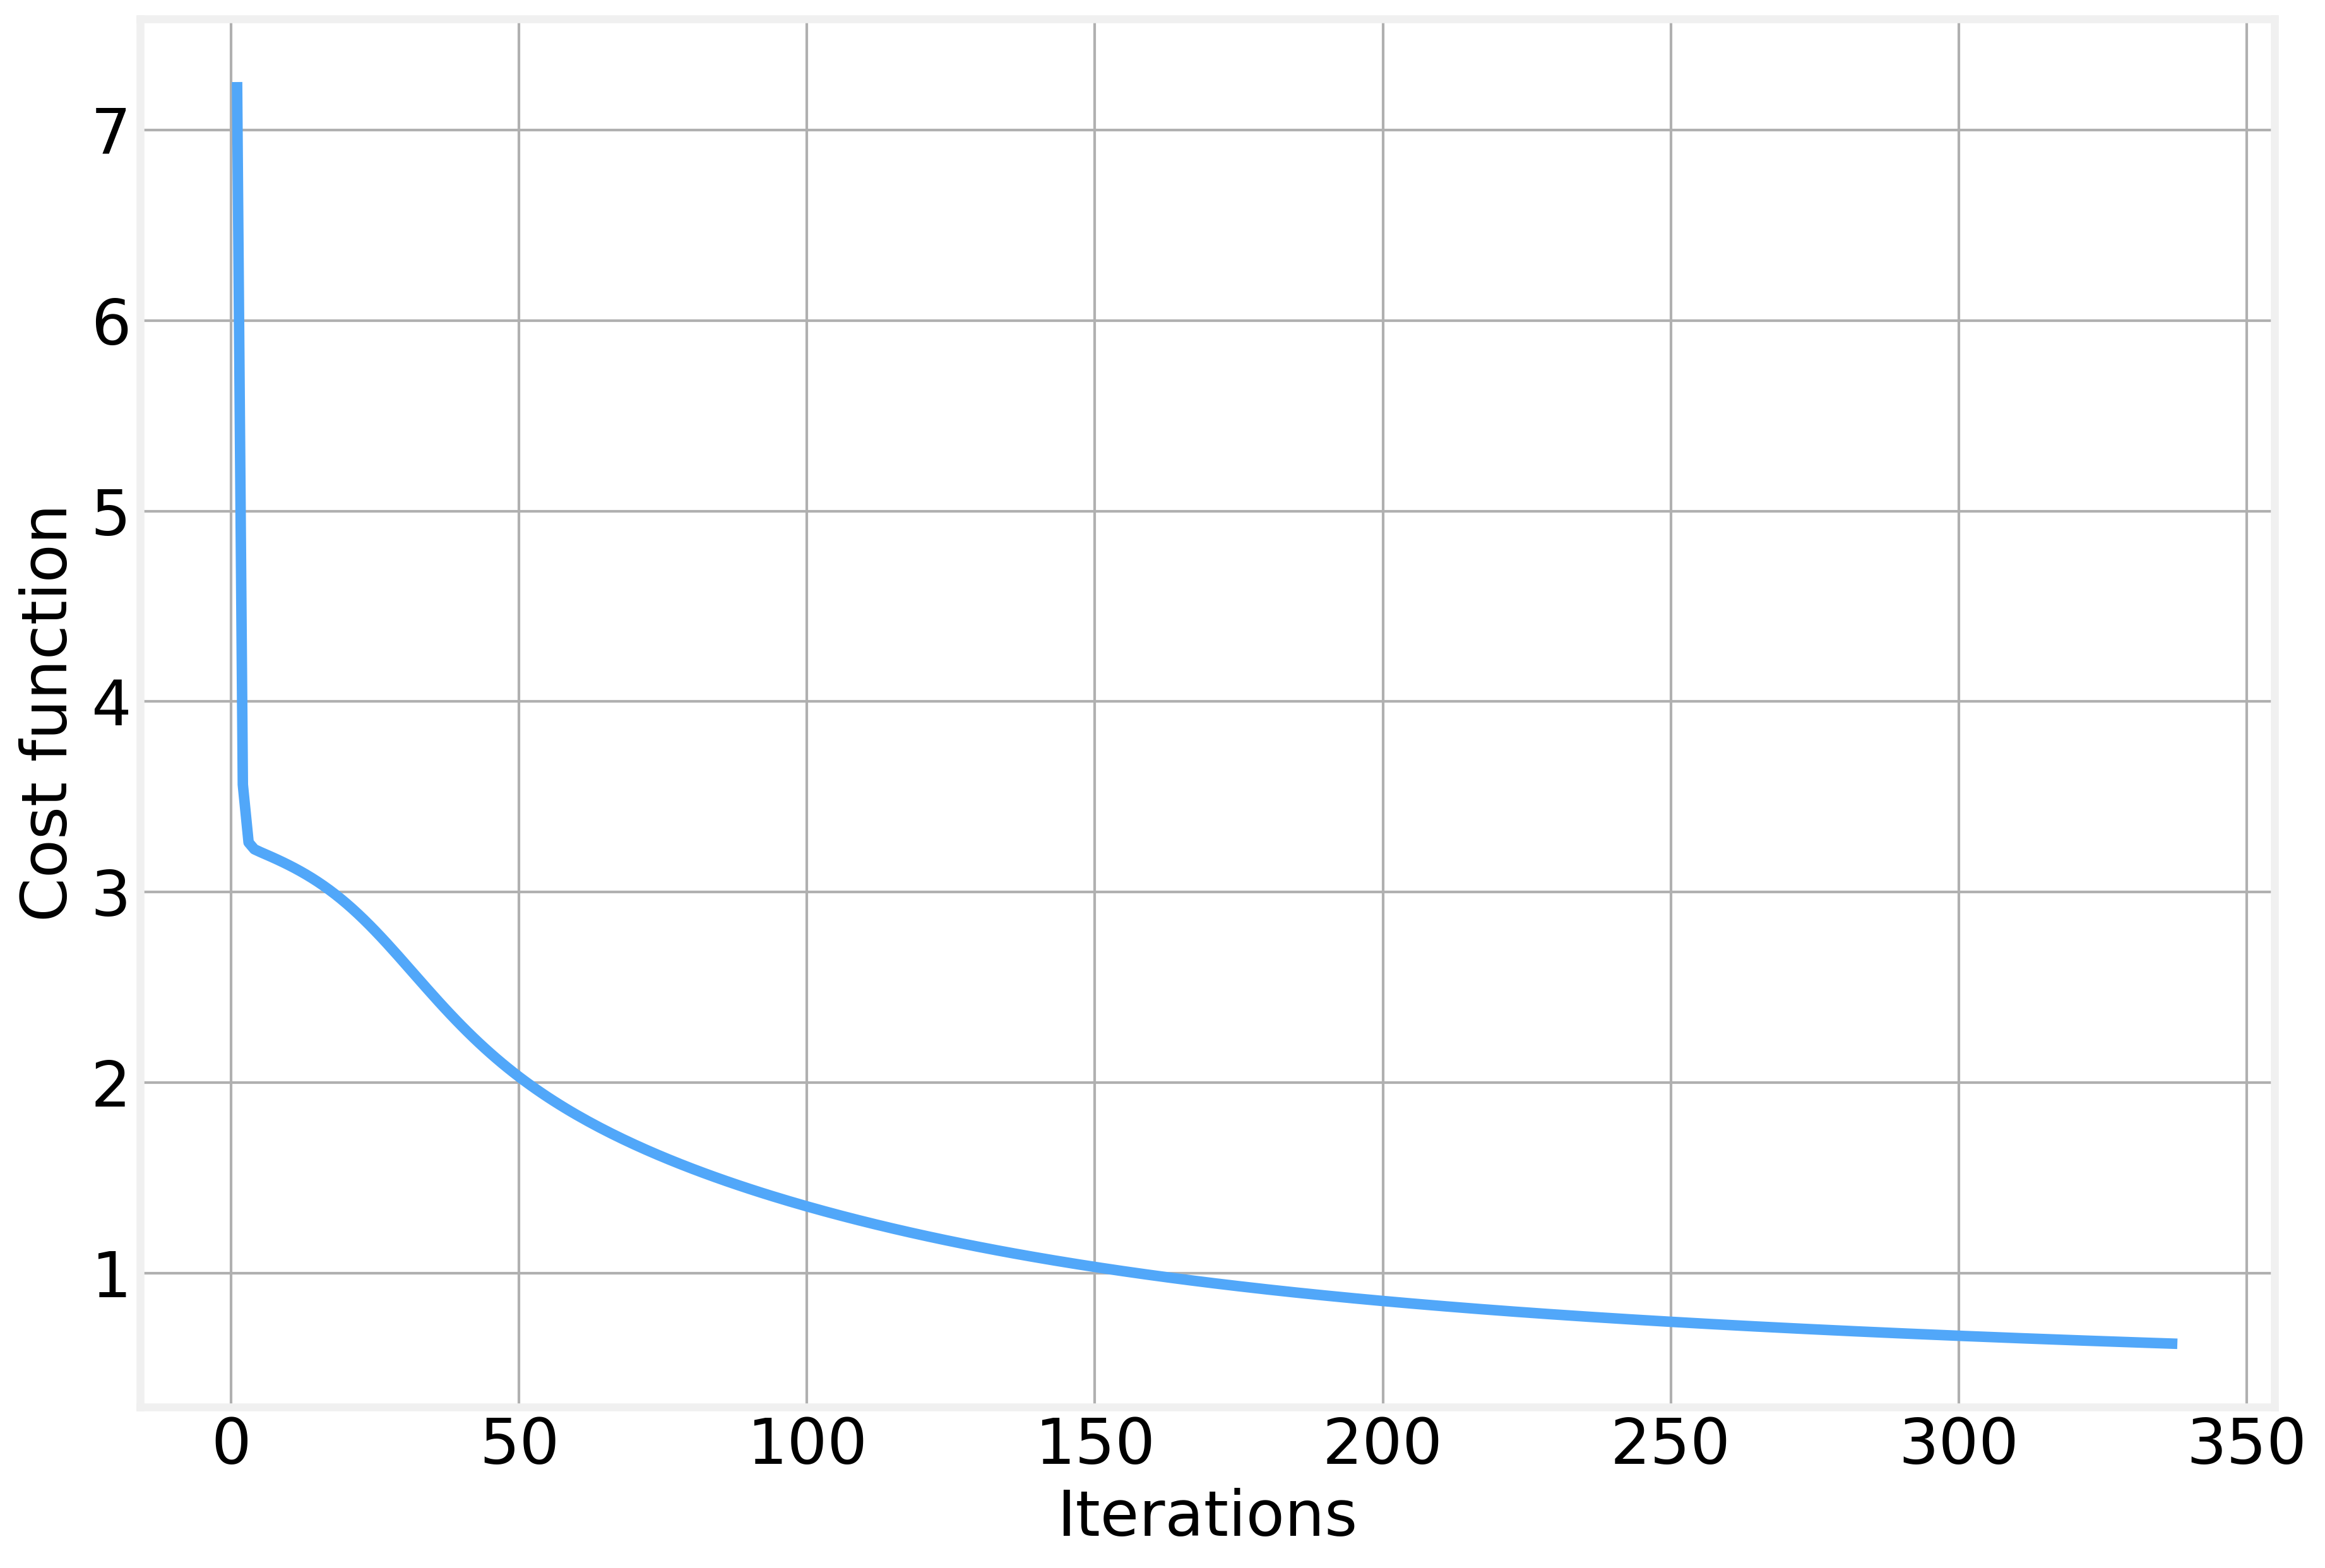

In [18]:
plt.plot(np.arange(1, len(J_val)+1), J_val)
plt.xlabel("Iterations")
plt.ylabel("Cost function")

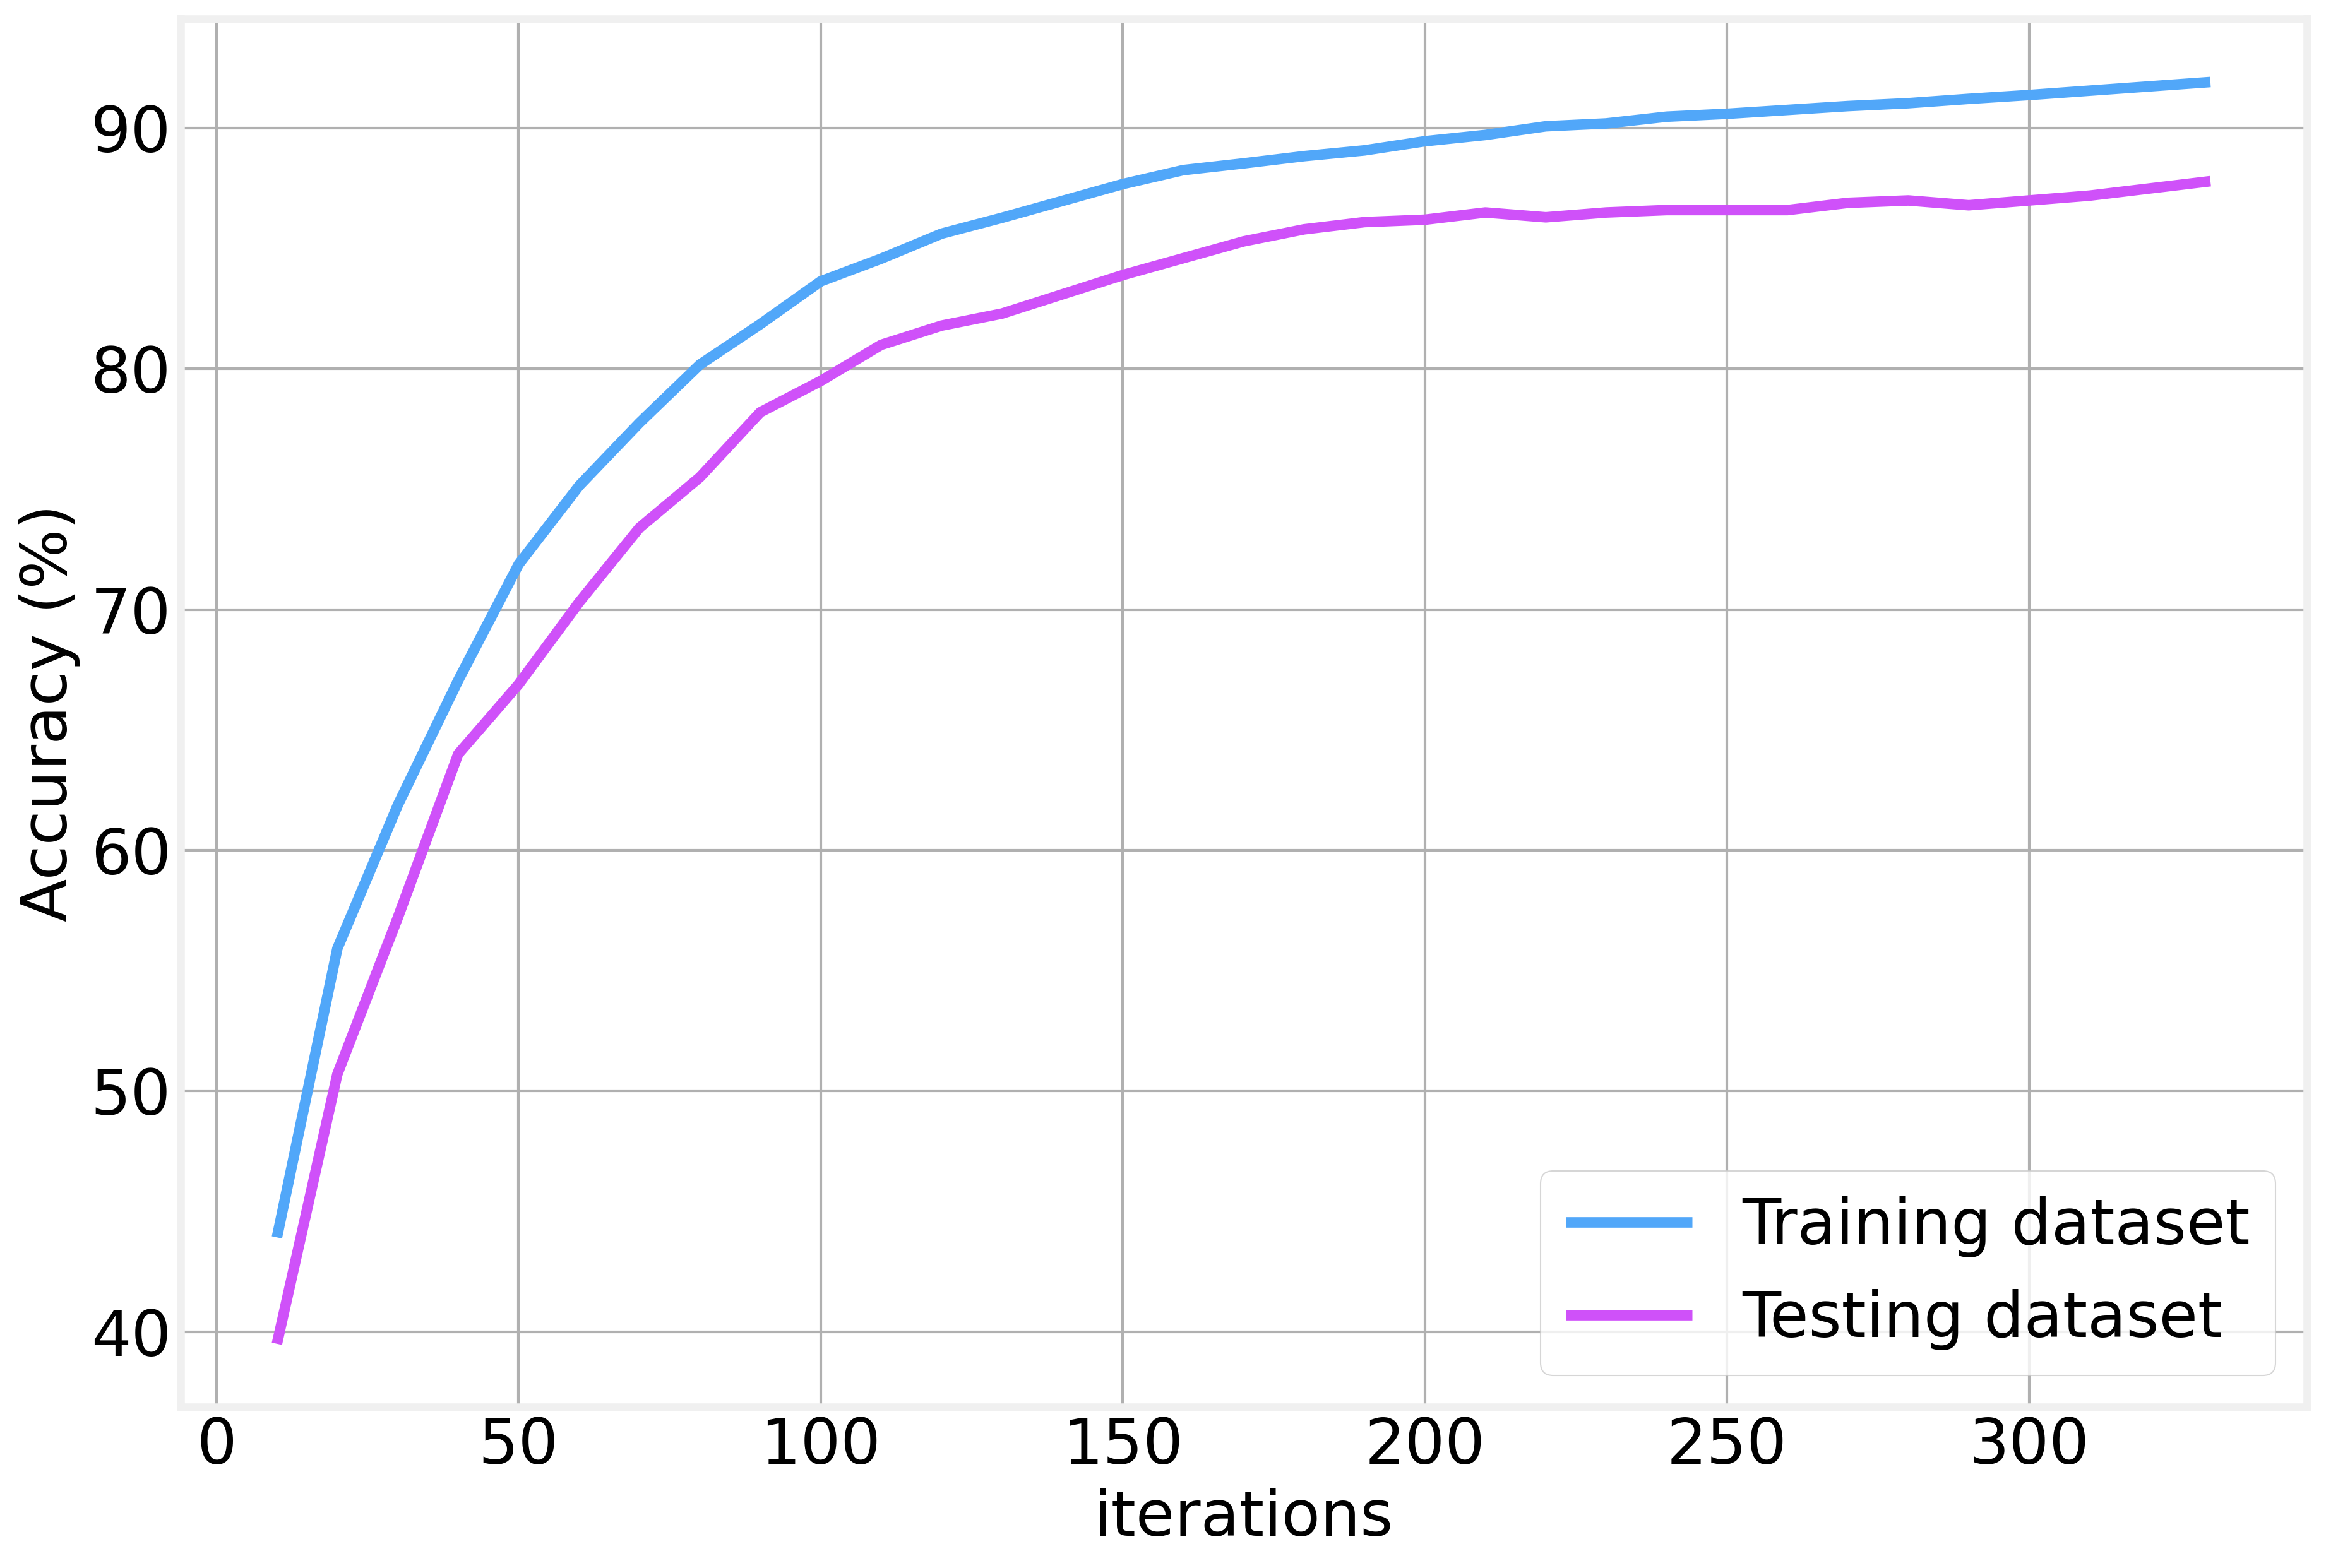

In [19]:
plt.plot(steps, acc_train, label='Training dataset')
plt.plot(steps, acc_test, label='Testing dataset')
plt.xlabel("iterations")
plt.ylabel("Accuracy (%)")
plt.legend()

Difference between the training and testing accuracies. We can see that it hits a minimum around ~200-250 epochs and starts increasing afterwards, indicating the beginning of overfitting

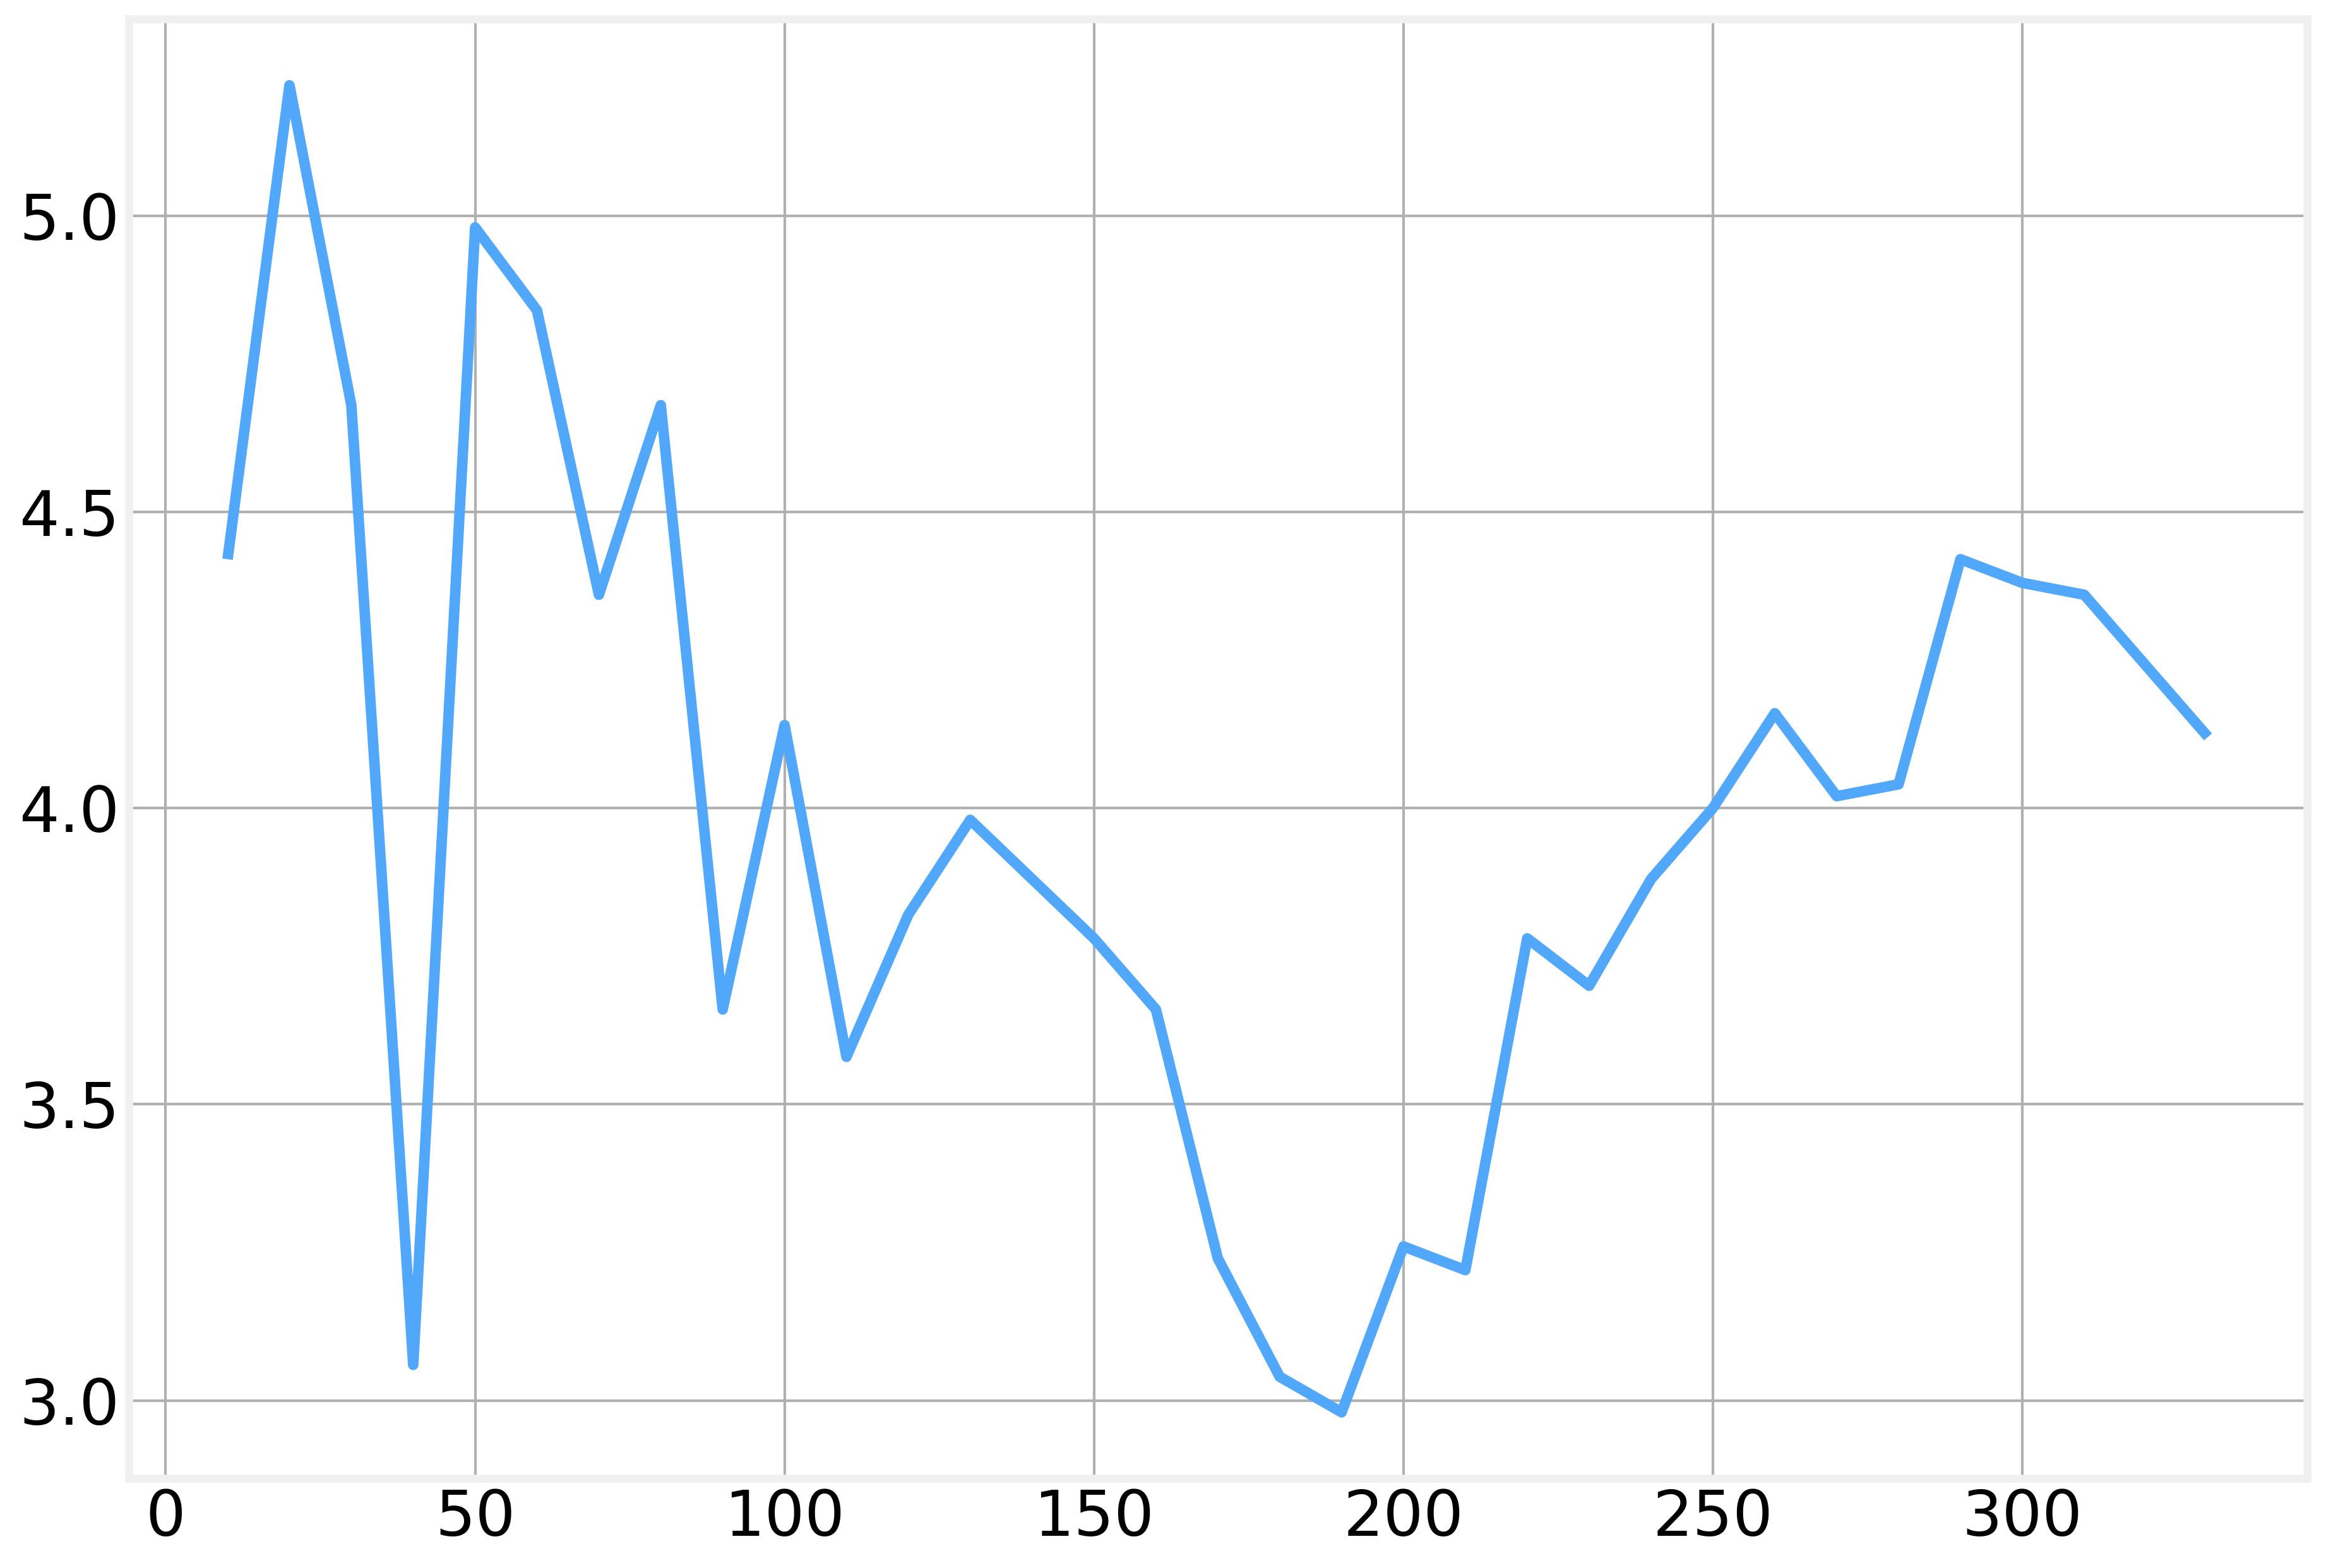

In [20]:
plt.plot(steps, np.array(acc_train)-np.array(acc_test))

<div style="width: 100%; overflow: hidden;">
     <img src="https://raw.githubusercontent.com/DataForScience/DeepLearning/master/data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>